# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions
 ### Results:
 * Done, the second model is in the same zip file
 * The model from the 3 task were giving the best results, and after 2 hours of training get stable (7 epochs), the same is for 4th model, but in this case the nearst neighbours were not that good, but the analogies were perfect. In the 5 models, we get a super fast training process, about 8 hours for (52 epochs), but the vectors were not that good for vanila, it seems that in nearest neighbours it is just random sets of words. But in batch_transpose model we achived good results, which show the semantic structure.

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?
### Answers:
1. I would name them to_maximize, to_minimize, dot_products_to_positive, dot_product_to_negative respectively, since by taking w.T @ w - 1. and summing up we are just summing the dot products of the words in one 2 * window_size + 1 window. We need to maximize this, and then we subtract the dot_products of i-th words in different windows, since we suggest that they are highly decorellated.
2. Firstly, we have to swap w.T and w, since we have to multiply embeddings.
    Secondly, dot product is beetwen 1 and -1, therefore by taking log_sigmoid we will maximize the overall probability (log(a * b) = log(a) + log(b)). Or we just add 1. and dividing by 2. in order to maximize cosine similarity, and this is equivalent to what is written in the formulae.
3. No, since here we predicting (word, word) pairs, not (context, word) pairs
4. Yes, we have to sample windows from different places of the text, in order to get decorellated pairs for the negative sampling. No in case of vanila model, there is no matter, we just have to itareto over all dataset (the negative samples are already known)




In [0]:
"""my implemenatation of word2vec embedding model with only one matrix of embeddings: https://arxiv.org/pdf/1411.2738.pdf"""
import tensorflow as tf
from tensorflow.train import AdamOptimizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorboardcolab import *
from operator import itemgetter

In [0]:
"""batcher class for the model"""
import numpy as np
import random
from collections import Counter

unknown_token = "UNK"

class SkipGramBatcher:
    def __init__(self, window_size=5, least_freq=3):
        self.least_freq = least_freq
        self.text = None
        self.vocab = None
        self.vocab_size = None
        self.word2index = None
        self.index2word = None
        self.window_size = window_size
        self.current_index = 0
        self.current_diff = -window_size
        self.total_size = 0
    
    def preprocess(self, text):
        """replace words with frequency < least_freq with unknown_token
        and save the text
        """
        counter = Counter(text)
        def get_token(word):
            if counter[word] < self.least_freq:
                return unknown_token
            else:
                return word.lower()
        self.text = [get_token(word) for word in text]
    
    def fit_text(self, text):
        """init text, vocab, word2ind, ind2word
        """
        self.preprocess(text)
        self.vocab = np.unique(self.text)
        self.vocab_size = self.vocab.shape[0]
        self.word2index = dict(zip(self.vocab, range(self.vocab.shape[0])))
        self.index2word = dict(zip(range(self.vocab.shape[0]), self.vocab))
        self.total_size = (len(self.text) - 3 * self.window_size) * self.window_size * 2
        
    def most_frequent(self, num=25):
        """get most frequent words from the text"""
        counter = Counter(self.text)
        return counter.most_common(num)
        
    def least_frequent(self, num=25):
        """get least frequent words from the text"""
        counter = Counter(self.text)
        return counter.most_common()[:-num - 1:-1]
        
    def indices_to_words(self, x_batch):
        """return array of words out of array of indices"""
        return np.array([self.index2word[index] for index in x_batch])
    
    def words_to_indices(self, words):
        """return array of indices out of array of words"""
        return np.array([self.word2index[word] for word in words])
    
    def _get_next_index_and_diff(self, current_index, current_diff):
        if (current_diff == self.window_size):
            current_diff = -self.window_size
            current_index += 1
            current_index %= len(self.text)
        else:
            if current_diff == -1:
                current_diff = 1
            else:
                current_diff += 1
        return current_index, current_diff

    
    def get_batch(self, batch_size=100):
        """return batch of indices for x and for labels consequently"""
        x_batch = []
        labels_batch = []
        while len(x_batch) < batch_size:
            label_index_in_text = self.current_index + self.current_diff 
            if (label_index_in_text < 0 or label_index_in_text >= len(self.text)):
                index, diff = self._get_next_index_and_diff(self.current_index, self.current_diff)
                self.current_index = index
                self.current_diff = diff
                continue
                
            word = self.text[self.current_index]
            word_index = self.word2index[word]
            label = self.text[self.current_index + self.current_diff]
            label_index = self.word2index[label]
            
            x_batch.append(word_index)
            labels_batch.append(label_index)
            
            index, diff = self._get_next_index_and_diff(self.current_index, self.current_diff)
            self.current_index = index
            self.current_diff = diff
            
        assert len(x_batch) == batch_size
        assert len(labels_batch) == batch_size
        
        x_batch = np.array(x_batch)
        labels_batch = np.array(labels_batch)
        
        permut = np.random.permutation(range(batch_size))
        x_batch = x_batch[permut]
        labels_batch = labels_batch[permut]
        return x_batch, labels_batch
      
    def get_random_batch(self, batch_size=100):
        """return batch of bath_size index arrays of 2 * window_size + 1 words randomly"""
        batch = []
        
        center_indices = np.random.choice(np.arange(self.window_size + 100, len(self.text) - self.window_size - 100), batch_size, replace=False)
        indices = [ range(ind - self.window_size, ind + self.window_size + 1) for ind in center_indices]
        words = [itemgetter(*row)(self.text) for row in indices] 
        batch = [np.array([self.word2index[word] for word in row]) for row in words]
        
        batch = np.array(batch)
        return batch
        
    def batch_generator(self, batch_size=100):
        """generator for batch"""
        while True:
            x_batch, labels_batch = self.get_batch(batch_size)
            yield x_batch, labels_batch

In [4]:
"""preparing data for training, the data is text8 - preprocessed text with 17005208 words"""
!mkdir logs
!ls
!wget http://mattmahoney.net/dc/text8.zip

!ls
!unzip text8.zip

filename = 'text8' #file with the raw text
text = []
with open('text8', mode='r') as file:
    line = file.readline()
    while line:
        text += line.lower().split(' ')
        line = file.readline()

logs  sample_data
--2019-03-10 11:18:17--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   734KB/s    in 43s     

2019-03-10 11:19:00 (720 KB/s) - ‘text8.zip’ saved [31344016/31344016]

logs  sample_data  text8.zip
Archive:  text8.zip
  inflating: text8                   


In [0]:
"""initializing batcher for the model"""
batcher = SkipGramBatcher(window_size=3, least_freq=4)
batcher.fit_text(text[:1000000])

In [71]:
"""gpu usage"""
USE_GPU = True
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


In [0]:
"""function for weights initialization"""
def kaiming_normal(shape):
    return tf.random_normal(shape) * np.sqrt(2.0 / shape[0])

In [0]:
"""logging parameters"""
save_every = 200
loss_every = 100
summary_every = 200
log_every = 75
USE_TENSORBOARDCOLAB = False
model_name = 'batch_transpose_'

In [0]:
"""word2vec class"""
class Word2Vec:
    def __init__(self, vocab_size, embeddings_size, window_size):
        tf.reset_default_graph()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        self.vocab_size = vocab_size
        self.embeddings_size = embeddings_size
        self.window_size = window_size
        
    def close(self):
        tf.reset_default_graph()
        self.sess.close()
        
    def init_weights(self):
        self.w1 = tf.Variable(kaiming_normal((self.vocab_size, self.embeddings_size)), name='w1') 
        
    def multiply_tensors(self, x, w):
        n = tf.reshape(x, [-1, x.shape[2]])
        h = tf.matmul(n, w)
        return tf.reshape(h, [-1, x.shape[1], w.shape[1]])

    def model_fn(self, x):
        x = self.multiply_tensors(x, self.w1)
        x = tf.math.l2_normalize(x, axis=2)
        return x
    
    def get_loss(self, scores):
        pos_dot_products = tf.matmul(scores, scores, transpose_b=True)
        pos_dot_products = tf.math.subtract(pos_dot_products, tf.ones_like(pos_dot_products))
        scores = tf.transpose(scores, perm=[1, 0, 2])
        neg_dot_products = tf.matmul(scores, scores, transpose_b=True)
        loss = -tf.reduce_sum(pos_dot_products) + tf.reduce_sum(neg_dot_products)
        return loss
    
    def train(self, batcher, batch_size=10, epochs=3, learning_rate=0.01):        
        with tf.device(device):
            self.init_weights()
            
            x = tf.placeholder(dtype=tf.int32, shape=(batch_size, 2 * self.window_size + 1))           
            
            x_one_hot = tf.one_hot(x, self.vocab_size, axis=-1)
            
            scores = self.model_fn(x_one_hot)
            loss = self.get_loss(scores)
            tf.summary.scalar('cross_entropy', loss)
            
            train_op = AdamOptimizer(learning_rate).minimize(loss)
            
            saver = tf.train.Saver({"w1" : self.w1})
            merged = tf.summary.merge_all()
            
            if USE_TENSORBOARDCOLAB:
                tbc = TensorBoardColab()
                train_writer = tbc.get_writer()
                print()
                print('initialized writer for tensorboard logging...')
                print()
            else:
                train_writer = tf.summary.FileWriter('./tensorboard/train')
            
            #training
            self.sess.run(tf.global_variables_initializer())
            
            min_loss = 1e9
            losses = []
            epoch_losses = []
            print('Starting training...')
            try:
                for epoch in range(epochs):
                    epoch_loss = 0
                    iter_count = int(batcher.total_size / batch_size)
                    for step in range(iter_count):
                        batch = batcher.get_random_batch(batch_size)
                        feed_dict = {x : batch}
                        
                        if step % summary_every == 0:
                            print('writing summary to tensorboard...')
                            print()
                            summary = self.sess.run(merged, feed_dict=feed_dict)
                            train_writer.add_summary(summary, iter_count * epoch + step)
                        
                        np_loss, _ = self.sess.run([loss, train_op], feed_dict=feed_dict)
                        epoch_loss += np_loss 
                        average_loss = epoch_loss / (step + 1)
                        
                        if step % log_every == 0:
                            print('running epoch: {}, step: {} out of {}, loss = {}...'.format(epoch, step, iter_count, average_loss))
                            print()

                        if min_loss > np_loss:
                            saver.save(self.sess, "./logs/" + model_name + "model_min_loss.ckpt")
                            print("minimal loss updated from {} to {} | at step {}...".format(min_loss, np_loss, step))
                            min_loss = np_loss
                            print("Model weights and loss saved in ./logs/" + model_name + "model_min_loss.ckpt | at step {}...".format(step))
                            print()
                        if step % save_every == 0:
                            saver.save(self.sess, "./logs/" + model_name + "model_default_save.ckpt")
                            print("Model with loss = {} saved to ./logs/" + model_name + "model_default_save.ckpt | at step {}...".format(average_loss, step))
                            print()
                        if step % loss_every == 0:
                            if len(losses) > 10000000:
                                print('Already a lot losses...')
                            else:
                                losses.append(average_loss)
                                print("Losses saved to ./logs/" + model_name + "losses_history... | at step {}".format(step))
                                print()
                                np.save("./logs/" + model_name + "losses_history", np.array(losses))
                    epoch_losses.append(epoch_loss / iter_count)
                    np.save("./logs/" + model_name + "epoch_losses", np.array(epoch_losses))
            except KeyboardInterrupt:
                print('KeyboardInterrupt')
    
    def get_vectors_from_words(self, batcher, words):
        if not isinstance(words, list):
            words = [words]
        with tf.device(device):
            indexes = [batcher.word2index[word] for word in words]
            x = tf.placeholder(dtype=tf.int32, shape=(len(indexes)))
            x_one_hot = tf.one_hot(x, self.vocab_size)
            x_one_hot = tf.cast(x_one_hot, tf.float32)
            predicted = tf.matmul(x_one_hot, self.w1)
           
            embeddings = self.sess.run(predicted, feed_dict={x : indexes})
            return embeddings
    
    def get_vectors_from_indexes(self, batcher, indexes):
        words = [batcher.index2word[index] for index in indexes]
        return self.get_vectors_from_words(batcher, words)

In [78]:
"""training the model (check tensorboard visualization) """
EMBEDDINGS_SIZE = 300
BATCH_SIZE = 1024
EPOCHS = 100
LEARNING_RATE = 0.01
model = Word2Vec(batcher.vocab_size, EMBEDDINGS_SIZE, batcher.window_size)
model.train(batcher, BATCH_SIZE, EPOCHS, LEARNING_RATE)

Starting training...
running epoch: 0, step: 0 out of 5859, loss = 140710.234375...

Losses saved to ./logs/batch_transpose_losses_history... | at step 0

running epoch: 0, step: 75 out of 5859, loss = 77305.17310855263...

Losses saved to ./logs/batch_transpose_losses_history... | at step 100

running epoch: 0, step: 150 out of 5859, loss = 63550.34964817881...

Losses saved to ./logs/batch_transpose_losses_history... | at step 200

running epoch: 0, step: 225 out of 5859, loss = 58743.31078885509...

running epoch: 0, step: 300 out of 5859, loss = 56362.353807620435...

Losses saved to ./logs/batch_transpose_losses_history... | at step 300

running epoch: 0, step: 375 out of 5859, loss = 54740.98495678192...

Losses saved to ./logs/batch_transpose_losses_history... | at step 400

running epoch: 0, step: 450 out of 5859, loss = 53570.41551759978...

Losses saved to ./logs/batch_transpose_losses_history... | at step 500

running epoch: 0, step: 525 out of 5859, loss = 52679.59397278992

In [0]:
"""plotting the vectors using TSNE"""
def plot_words(indixes, embeddings):
    """embeddings of shape num_values * embed_dimenssion"""
    tsne = TSNE(n_components=2, init="pca", n_iter=1000)
    transformed = tsne.fit_transform(embeddings)
    print('TSNE calculated...')
    
    plt.figure(figsize=(15, 15))
    words = [batcher.index2word[index] for index in indixes]
    for i, word in enumerate(words):
        x, y = transformed[i, :]
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

In [0]:
"""function to map token to corresponding word vector"""
embeddings = model.get_vectors_from_words(batcher, ['anarchism', 'UNK'])

(200, 300)
TSNE calculated...


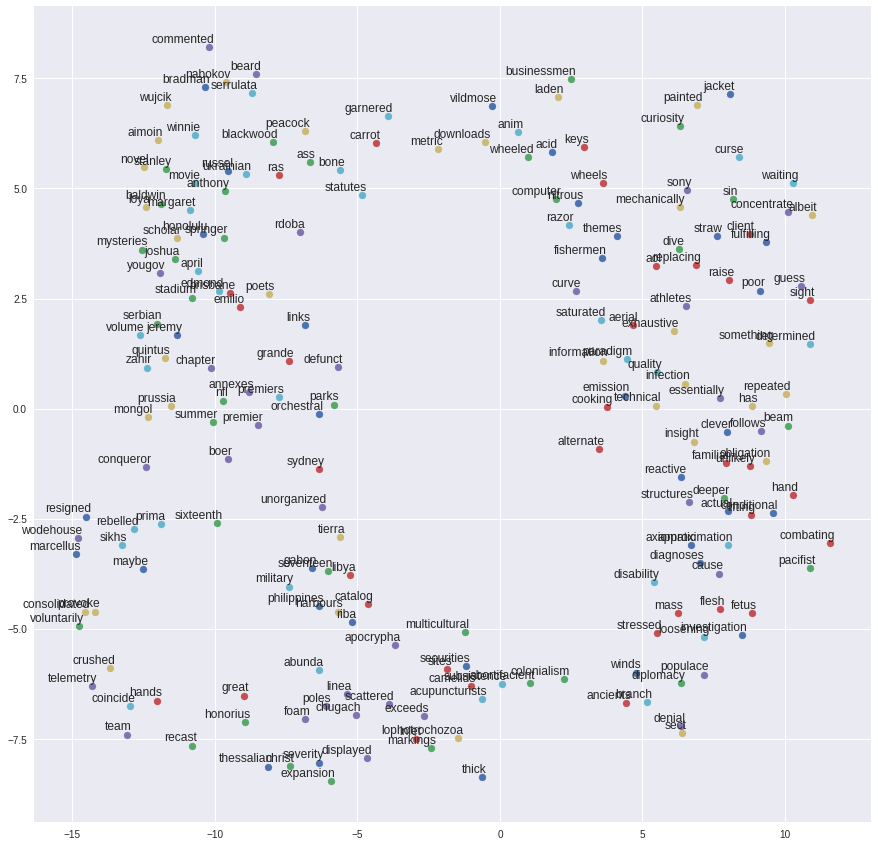

In [81]:
"""plotting the embeddings"""
indices = np.arange(batcher.vocab_size)
np.random.shuffle(indices)
indices = indices[:200]
embed_from_indices = model.get_vectors_from_indexes(batcher, indices)
print(embed_from_indices.shape)

plot_words(indices, embed_from_indices)

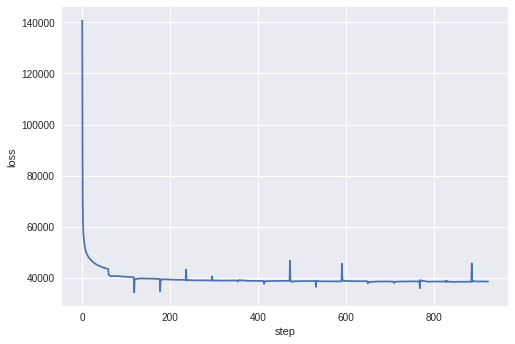

In [82]:
"""plot loss without tensorboard"""
losses = np.load("./logs/" + model_name + "losses_history.npy")
plt.xlabel('step')
plt.ylabel('loss')
plt.plot(losses)
plt.show()

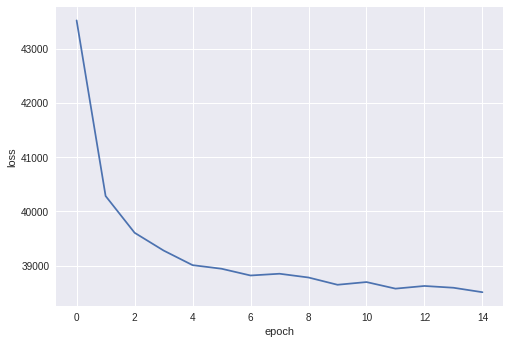

In [83]:
epoch_losses = np.load("./logs/" + model_name + "epoch_losses.npy")
plt.plot(epoch_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [84]:
print(batcher.vocab_size)
embeddings = model.get_vectors_from_indexes(batcher, range(batcher.vocab_size))

16525


In [0]:
"""nearest neighbors, word analogies using gensim"""
def create_file_for_gensim(embeddings, vocab_size, vec_size, filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size) + ' ' + str(vec_size) + '\n')
        for i in range(vocab_size):
            to_write = ' '.join([batcher.index2word[i]] + [str(num) for num in embeddings[i]])
            f.write(to_write + '\n')

create_file_for_gensim(embeddings, embeddings.shape[0], EMBEDDINGS_SIZE, 'word2vec.vec')

In [0]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('word2vec.vec', binary=False)

def print_similar(similar_to):
  for similar in w2v.similar_by_word(similar_to)[:20]:
      print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

In [89]:
print_similar('moscow')

word: solomon, similarity: 1.00
word: queensland, similarity: 1.00
word: portugal, similarity: 1.00
word: olaf, similarity: 1.00
word: kabul, similarity: 0.99
word: hungarian, similarity: 0.99
word: encyclopaedia, similarity: 0.99
word: festivals, similarity: 0.99
word: leningrad, similarity: 0.99
word: latvia, similarity: 0.99


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [90]:
print_similar('king')

word: president, similarity: 1.00
word: pennsylvania, similarity: 1.00
word: sultan, similarity: 1.00
word: venice, similarity: 1.00
word: walton, similarity: 1.00
word: maryland, similarity: 1.00
word: iliad, similarity: 1.00
word: florida, similarity: 1.00
word: filipino, similarity: 1.00
word: rutgers, similarity: 1.00


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [93]:
"""here high is an antonymous"""
similar_words = w2v.most_similar(positive=['white', 'small'], negative=['black'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: nitrogen, similarity: 1.00
word: disease, similarity: 1.00
word: surgical, similarity: 0.99
word: alcohol, similarity: 0.99
word: salts, similarity: 0.99
word: resistivity, similarity: 0.99
word: ornamental, similarity: 0.99
word: high, similarity: 0.99
word: compounds, similarity: 0.99
word: organ, similarity: 0.99


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [92]:
"""princess is close to queen"""
similar_words = w2v.most_similar(positive=['king', 'woman'], negative=['man'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: babylon, similarity: 1.00
word: saint, similarity: 1.00
word: hungary, similarity: 0.99
word: multiplied, similarity: 0.99
word: amp, similarity: 0.99
word: judas, similarity: 0.99
word: albert, similarity: 0.99
word: roy, similarity: 0.99
word: princess, similarity: 0.99
word: bulgaria, similarity: 0.99


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
"""nearest neighbors, word analogies using my own implemetation"""
"""as it can be seen we got the same results!!!!!!!!!"""
"""as we see one matrix model is good for word analogies, but not for nearest neighbours"""
def get_similar_by_word(embeddings, similar_to, num_top=10):
    index = batcher.word2index[similar_to]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        nearby_index = tf.placeholder(tf.int32, shape=(), name='nearby_index')
        nearby_embed = tf.gather(norm_embed, nearby_index)
        nearby_embed = tf.reshape(nearby_embed, (1, -1))
        nearby_dist = tf.matmul(nearby_embed, norm_embed, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, nearby_index : index}
        vals, idxs = model.sess.run([nearby_val, nearby_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten()[1:], words[1:]
      
def get_analogy_by_word(embeddings, positive, negative, num_top=10):
    a = batcher.word2index[negative[0]]
    b = batcher.word2index[positive[0]]
    c = batcher.word2index[positive[1]]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        a_index = tf.placeholder(tf.int32, shape=(), name='a_index')
        b_index = tf.placeholder(tf.int32, shape=(), name='b_index')
        c_index = tf.placeholder(tf.int32, shape=(), name='c_index')
        a_embed = tf.reshape(tf.gather(norm_embed, a_index), (1, -1))
        b_embed = tf.reshape(tf.gather(norm_embed, b_index), (1, -1))
        c_embed = tf.reshape(tf.gather(norm_embed, c_index), (1, -1))
        target_embed = c_embed + b_embed - a_embed
        target_dist = tf.matmul(target_embed, norm_embed, transpose_b=True)
        target_val, target_idx = tf.nn.top_k(target_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, a_index : a, b_index : b, c_index : c}
        vals, idxs = model.sess.run([target_val, target_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten(), words


In [99]:
vals, words = get_similar_by_word(embeddings, 'movie')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: film, similarity: 1.00
word: xbox, similarity: 1.00
word: agatha, similarity: 1.00
word: sharon, similarity: 1.00
word: ang, similarity: 1.00
word: circa, similarity: 1.00
word: appearing, similarity: 1.00
word: cub, similarity: 1.00
word: titled, similarity: 1.00


In [104]:
vals, words = get_similar_by_word(embeddings, 'china')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: canada, similarity: 1.00
word: kuwait, similarity: 1.00
word: turkish, similarity: 1.00
word: sadr, similarity: 1.00
word: latvia, similarity: 1.00
word: browne, similarity: 1.00
word: bangladesh, similarity: 0.99
word: russia, similarity: 0.99
word: bavaria, similarity: 0.99


In [120]:
vals, words = get_similar_by_word(embeddings, 'apple')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: microsoft, similarity: 0.99
word: dom, similarity: 0.98
word: cd, similarity: 0.98
word: ibm, similarity: 0.98
word: fm, similarity: 0.98
word: imac, similarity: 0.97
word: omega, similarity: 0.97
word: bose, similarity: 0.97
word: pi, similarity: 0.97


In [135]:
vals, words = get_similar_by_word(embeddings, 'usa')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: ghana, similarity: 1.00
word: boulevard, similarity: 1.00
word: hall, similarity: 1.00
word: park, similarity: 1.00
word: saskatchewan, similarity: 1.00
word: belgium, similarity: 1.00
word: maldives, similarity: 1.00
word: ames, similarity: 1.00
word: normandy, similarity: 1.00


In [143]:
vals, words = get_analogy_by_word(embeddings, positive=['white', 'small'], negative=['black'])
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: nitrogen, similarity: 1.45
word: disease, similarity: 1.45
word: surgical, similarity: 1.45
word: alcohol, similarity: 1.45
word: salts, similarity: 1.45
word: resistivity, similarity: 1.45
word: ornamental, similarity: 1.45
word: high, similarity: 1.45
word: compounds, similarity: 1.45
word: organ, similarity: 1.45


In [137]:
vals, words = get_analogy_by_word(embeddings, positive=['woman', 'king'], negative=['man'])
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: babylon, similarity: 1.39
word: saint, similarity: 1.39
word: hungary, similarity: 1.39
word: multiplied, similarity: 1.39
word: amp, similarity: 1.39
word: judas, similarity: 1.39
word: albert, similarity: 1.39
word: roy, similarity: 1.39
word: princess, similarity: 1.39
word: bulgaria, similarity: 1.39


In [0]:
np.save("./logs/" + model_name + "embeddings", embeddings)

In [0]:
"""download graph and loss to visualize them localy (ngrock is too slow with VPN) """
from google.colab import files
files.download("./logs/" + model_name + "embeddings.npy") 

In [0]:
"""model destructor (closses tf.Session())"""
model.close()